In [2]:
import io
import numpy as np
import os
from osgeo import gdal
import ee
import pandas as pd
import geopandas as gpd
import json

import matplotlib.pyplot as plt

import shapely



In [3]:

def geotiff_to_xyz(in_geotiff, out_xyz_path):
    format = "XYZ"
    driver = gdal.GetDriverByName(format)
    out_csv = out_xyz_path.replace("parquet.gzip", "csv")
    # Output to new format
    ds = gdal.Open(in_geotiff, gdal.GA_ReadOnly)
    nodata = ds.GetRasterBand(1).GetNoDataValue()
    driver.CreateCopy(out_csv, ds, -999)

    # BUILD XYZ dataset
    xyz = pd.read_csv(out_csv, sep=" ", names=["lon", "lat", "value"], header=None)
    xyz = xyz.reset_index()
    xyz.loc[xyz['value'] == "-nan(ind)", "value"] = ""
    xyz["lon"] = xyz["lon"].round(2)
    xyz["lat"] = xyz["lat"].round(2)

    xyz["value"] = pd.to_numeric(xyz["value"]).round(4)

    xyz = xyz.dropna()
    xyz = xyz.loc[~(xyz.value == nodata)]
    xyz = xyz.loc[~(xyz.value == -999)]
    xyz[["lat", "lon", "value"]].to_parquet(out_xyz_path, compression="gzip")
    os.remove(out_csv)

    return True

def warp_to_resolution(in_path,out_path,resolution):
    # Resample with GDAL warp
    source_image_metadata = gdal.Open(in_path,gdal.GA_ReadOnly)
    geo_t = source_image_metadata.GetGeoTransform()
    x_size=source_image_metadata.RasterXSize
    y_size=source_image_metadata.RasterYSize
    xmin = min(geo_t[0], geo_t[0] + x_size * geo_t[1])
    xmax = max(geo_t[0], geo_t[0] + x_size * geo_t[1])
    ymin = min(geo_t[3], geo_t[3] + y_size * geo_t[5])
    ymax = max(geo_t[3], geo_t[3] + y_size * geo_t[5])

    xmin =int(xmin / resolution) * resolution - resolution
    xmax = int(xmax / resolution) * resolution + resolution
    ymin= int(ymin / resolution) * resolution - resolution
    ymax = int(ymax / resolution) * resolution + resolution


    try:
        gdal.Warp(out_path,
                          in_path,
                          dstSRS='EPSG:4326',
                          outputType=gdal.GDT_UInt16,
                          xRes=resolution, yRes=resolution,
                          resampleAlg="average",
                          options=['-te', str(xmin), str(ymin), str(xmax), str(ymax)]
                          )





        return True
    except Exception as e:
        print(e)


def getArea(GID_0,LEVEL_AGG):
    area = gpd.read_file(f'reference_datasets/gadm_401_GID_1/{GID_0[0:3]}.gpkg')
    if LEVEL_AGG == "GID_0":
        area = area.dissolve("GID_0").reset_index()
        area.drop(columns=['GID_1', 'NAME_1'], axis=1, inplace=True )

    if LEVEL_AGG == "GID_1":
        area = area.loc[area.GID_1 == GID_0]
        area = area.dissolve("GID_1").reset_index()
        area.drop(columns=['GID_0', 'NAME_0'], axis=1, inplace=True )


    area = ee.FeatureCollection(json.loads(area.to_json()))
    return area


class MyGEEClass:
    def __init__(self):

        self.SATELLITE = None
        self.SCALE = None
        self.BANDS = None
        self.START_DATE = None
        self.END_DATE = None
        self.OUTPATH = None


    def get_any_image_median(self):

        self.SCALE = ee.ImageCollection(self.SATELLITE).first().projection().nominalScale().getInfo()

        image = ee.ImageCollection(self.SATELLITE) \
            .filterDate(self.START_DATE, self.END_DATE) \
            .filterBounds(self.REGION)

        image = image.median().clip(self.REGION).uint16()
        image = image.mask(image.mask())

        return image

    def get_image_to_garray(self):
        response = self.get_image_url()
        data = np.load(io.BytesIO(response.content))
        return data

    def get_image_url(self):
        import requests
        image = self.image

        path = image.getDownloadUrl({
            'bands': self.BANDS,
            'scale': self.SCALE,
            'crs': "EPSG:4326",
            'region': self.REGION.geometry(),
            'format': 'GEO_TIFF'
        })

        response = requests.get(path)
        return response

    def get_image_to_file(self):
        if not os.path.exists(self.output_dir):
            os.makedirs(self.output_dir)

        response = self.get_image_url()

        with open(self.output_file, 'wb') as fd:
                fd.write(response.content)



In [19]:

credentials = ee.ServiceAccountCredentials(
    "test1-landsat8@geelandsat8.iam.gserviceaccount.com",
    "geelandsat8-6af86334d7ec.json",
)
ee.Initialize(credentials)

GadmGID = 'ITA.16_1'
GadmLevel = "GID_1"
BANDS = 'NDVI'
SATELLITE = "MODIS/061/MOD13A1"
YEAR = 2000
out_file_name="some_name.tiff"
out_path = "output_TIFF"

myImg = MyGEEClass()

myImg.BANDS = BANDS.split(",")
myImg.SATELLITE = SATELLITE


myImg.REGION = getArea(GadmGID,GadmLevel)

myImg.START_DATE = f"{YEAR}-01-01"
myImg.END_DATE = f"{YEAR+1}-01-01"
myImg.filename = out_file_name
myImg.output_dir = out_path
myImg.output_file = f"{out_path}/{out_file_name}"

try:
    myImg.image = myImg.get_any_image_median()
    myImg.get_image_to_file()
except Exception as e:
    print(e)


In [17]:
GEOTIFF_raw = gdal.Open(myImg.output_file)
GEOTIFF_raw.ReadAsArray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)

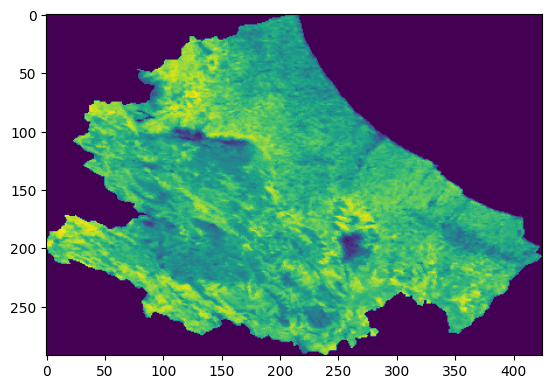

In [18]:
plt.imshow(GEOTIFF_raw.ReadAsArray())

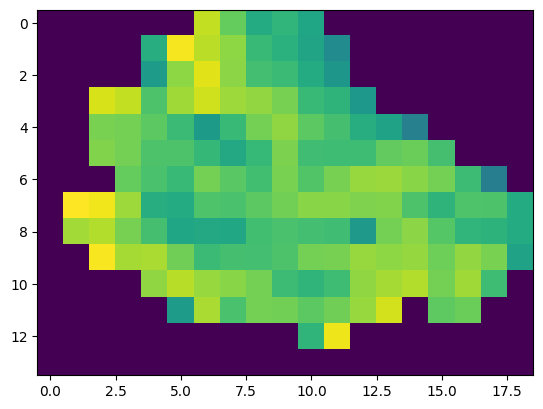

In [12]:
out_file_warped_to_res = myImg.output_file.replace(".tiff","_warped_to_res.tiff")
warp_to_resolution(myImg.output_file,out_file_warped_to_res,0.1)
GEOTIFF_to_resolution = gdal.Open(out_file_warped_to_res)
plt.imshow(GEOTIFF_to_resolution.ReadAsArray())

In [8]:

out_file_warped_to_res_xyz = myImg.output_file.replace(".tiff","_warped_to_res_xyz.parquet.gzip")
geotiff_to_xyz(out_file_warped_to_res, out_file_warped_to_res_xyz)
xyz = pd.read_parquet(out_file_warped_to_res_xyz)
xyz


,lat,lon,value
2,44.45,9.75,6813
3,44.45,9.85,6961
4,44.45,9.95,6928
5,44.45,10.05,6296
30,44.35,9.65,7112
...,...,...,...
626,42.35,11.25,5021
627,42.35,11.35,4141
628,42.35,11.45,5352
653,42.25,11.05,6663
